In [84]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from skimage.io import imread
from torchinfo import summary


### Build dataloader

In [85]:
class MyoDataSet(Dataset):
    def __init__(self, image_stack, len_in):
        super().__init__()

        self.data = torch.tensor(image_stack)
        self.len_in = len_in

    def __len__(self):
        return len(self.data)-self.len_in+1

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        x = {'input': self.data[idx:idx+self.len_in], 
             'target': self.data[idx:idx+self.len_in]}
        
        return x

    def get_loader(self, indices, batch_size, num_workers, pin_memory=True):
        sampler = SubsetRandomSampler(indices)
        loader = torch.utils.data.DataLoader(self, 
            batch_size=batch_size,
            num_workers=num_workers, # number of cores to use, I usually just choose either 0 or 4
            sampler=sampler, 
            pin_memory=pin_memory) # pin memory should be true if you are transferring data between cpu and gpu
        return loader



TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


(41, 128, 128)


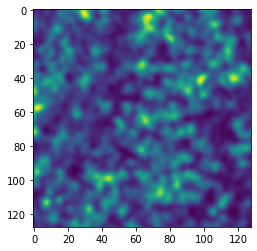

In [86]:
fpath = 'data/WT_cell1_cutout1.tif'
im1 = imread(fpath).astype('float32')
print(im1.shape)
plt.imshow(im1[0])

In [87]:
testSet = MyoDataSet(im1, 6)
test = testSet[3]
test['input'].shape

torch.Size([6, 128, 128])

In [101]:
loader = testSet.get_loader(np.arange(len(testSet)), 4, 0)
x = next(iter(loader))
print(len(loader))
#print(target.shape)

9


In [127]:
output_size = (6, 128, 128)
upsample_factor = 2
layers = 3
neck_dim = 1000

target_fmaps, h, w = tuple(output_size)
bottom_h = int(h * upsample_factor**(-layers))
bottom_w = int(w * upsample_factor**(-layers))
in_channel = int(target_fmaps * np.power(upsample_factor, layers))
        
dense1 = in_channel * bottom_h * bottom_w

upNeck = nn.Sequential(nn.Linear(neck_dim, dense1), nn.ReLU(), nn.Dropout())

decoderList = []

current_fmaps = in_channel

for ii in range(layers):
    out_fmaps = int(current_fmaps / upsample_factor)
    decoderList += [nn.ConvTranspose2d(current_fmaps, out_fmaps, kernel_size = upsample_factor, stride = upsample_factor),
                    nn.BatchNorm2d(out_fmaps),
                    nn.ReLU()]
    current_fmaps = out_fmaps
        
decoderList.pop(-1)
decoder = nn.Sequential(*decoderList)

x = torch.randn(4, 1000)

m = upNeck(x)
m = m.view(-1, in_channel, bottom_h, bottom_w)
m = decoder(m)
print(m.shape)

torch.Size([4, 6, 128, 128])


### Define convolutional autoencoder

In [130]:
class encoderNN(nn.Module):
    def __init__(self, input_size=(6, 128, 128), layers=3, downsample_factor=2, neck_dim=1000):
        super().__init__()

        current_fmaps, h, w = tuple(input_size)
        current_size = (h, w)
        # List of encoder layers
        encoderList = []
        for ii in range(layers):
            out_fmap = current_fmaps * downsample_factor
            encoderList += [nn.Conv2d(current_fmaps, out_fmap, kernel_size=(3,3), padding=1),
                         #nn.BatchNorm2d(out_fmap),
                         nn.ReLU(),
                         nn.MaxPool2d((downsample_factor, downsample_factor))]
            current_fmaps = out_fmap
            h = int(h/downsample_factor)
            w = int(w/downsample_factor)
        
        self.encoder = nn.Sequential(*encoderList)
        self.bottom_h = h
        self.bottom_w = w

        # List of bottleneck layers
        dense1 = current_fmaps*h*w
        neckList = [nn.Flatten(),
                    nn.Linear(dense1, neck_dim),
                    nn.ReLU(),
                    nn.Dropout()]

        self.bottleneck = nn.Sequential(*neckList)

    def forward(self, x):
        x = self.encoder(x)
        x = self.bottleneck(x)
        return x


class decoderNN(nn.Module):
    def __init__(self, neck_dim=1000, output_size=(6, 128, 128), layers=3, upsample_factor=2):
        super().__init__()

        target_fmaps, h, w = tuple(output_size)
        self.bottom_h = int(h * upsample_factor**(-layers))
        self.bottom_w = int(w * upsample_factor**(-layers))
        self.in_channel = int(target_fmaps * np.power(upsample_factor, layers))

        dense1 = self.in_channel * self.bottom_h * self.bottom_w

        self.upNeck = nn.Sequential(nn.Linear(neck_dim, dense1), nn.ReLU(), nn.Dropout())

        decoderList = []

        current_fmaps = self.in_channel
        for ii in range(layers):
            out_fmaps = int(current_fmaps / upsample_factor)
            decoderList += [nn.ConvTranspose2d(current_fmaps, out_fmaps, kernel_size = upsample_factor, stride = upsample_factor),
                            nn.BatchNorm2d(out_fmaps),
                            nn.ReLU()]
            current_fmaps = out_fmaps
        
        decoderList.pop(-1)
        self.decoder = nn.Sequential(*decoderList)

    def forward(self, x):
        x = self.upNeck(x)
        x = x.view(-1, self.in_channel, self.bottom_h, self.bottom_w)
        x = self.decoder(x)
        return x


class CAE(nn.Module):
    def __init__(self, input_size = (6, 128, 128), layers = 3, sample_factor = 2, neckdim = 1000):
        super().__init__()
        self.input_size = input_size
        self.layers = layers
        self.sample_factor = sample_factor
        self.neckdim = neckdim

        self.encoding = encoderNN(self.input_size, self.layers, self.sample_factor, self.neckdim)
        self.decoding = decoderNN(self.neckdim, self.input_size, self.layers, self.sample_factor)
        
    def forward(self, x):
        encoded = self.encoding(x)
        decoded = self.decoding(encoded)
        return decoded

In [131]:
# Print model summary
input_size = (6, 128, 128)
layers = 3
sample_factor = 2
neckdim = 1000
model = CAE(input_size, layers, sample_factor, neckdim)
summary(model, input_size=(4, 6, 128, 128))       # Input size for torchinfo needs to have the size (B,C,H,W)

Layer (type:depth-idx)                   Output Shape              Param #
CAE                                      [4, 6, 128, 128]          --
├─encoderNN: 1-1                         [4, 1000]                 --
│    └─Sequential: 2-1                   [4, 48, 16, 16]           --
│    │    └─Conv2d: 3-1                  [4, 12, 128, 128]         660
│    │    └─ReLU: 3-2                    [4, 12, 128, 128]         --
│    │    └─MaxPool2d: 3-3               [4, 12, 64, 64]           --
│    │    └─Conv2d: 3-4                  [4, 24, 64, 64]           2,616
│    │    └─ReLU: 3-5                    [4, 24, 64, 64]           --
│    │    └─MaxPool2d: 3-6               [4, 24, 32, 32]           --
│    │    └─Conv2d: 3-7                  [4, 48, 32, 32]           10,416
│    │    └─ReLU: 3-8                    [4, 48, 32, 32]           --
│    │    └─MaxPool2d: 3-9               [4, 48, 16, 16]           --
│    └─Sequential: 2-2                   [4, 1000]                 --
│    │ 

### Define model training/validation

In [133]:
## To do: move to device, log tensorboard, metric for validation? training rate scheduler?

def train(model, dataloader, lossfn, optimizer):     # Training step for each epoch
    model.train()

    totalLoss = 0
    optimizer.zero_grad()
    for minibatch in dataloader:
        y = model(minibatch['input'])
        loss = lossfn(y, minibatch['target'])
        loss.backward()
        optimizer.step()
        totalLoss += loss

    return totalLoss

def validate(model, dataloader, lossfn):      # Validate after each epoch, returns the loss 
    model.eval()

    x = next(iter(dataloader))
    y = model(x['input'])
    loss = lossfn(y, x['target'])

    return loss

loss = torch.nn.MSELoss()
optim = torch.optim.Adam(params = model.parameters(), lr = 1e-4)

numEpoch = 100
for ii in range(numEpoch):
    epochLoss = train(model, loader, loss, optim)
    validLoss = validate(model, loader, loss)
    print("Epoch ", ii, "    Training loss: ", epochLoss.detach().cpu().numpy(), ", Validation loss: ", validLoss.detach().cpu().numpy())
    

Epoch  0     Training loss:  4025748.2 , Validation loss:  520413.6
Epoch  1     Training loss:  4025634.8 , Validation loss:  422242.78
Epoch  2     Training loss:  4025481.5 , Validation loss:  448314.62
Epoch  3     Training loss:  4025350.2 , Validation loss:  508634.16
Epoch  4     Training loss:  4025187.0 , Validation loss:  503729.47


KeyboardInterrupt: 